In [4]:
pip install mplfinance

  Obtaining dependency information for mplfinance from https://files.pythonhosted.org/packages/d7/d9/31c436ea7673c21a5bf3fc747bc7f63377582dfe845c3004d3e46f9deee0/mplfinance-0.12.10b0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/75.0 kB ? eta -:--:--
   -------------------------------- ------- 61.4/75.0 kB 3.2 MB/s eta 0:00:01
   ---------------------------------------- 75.0/75.0 kB 2.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import math
import random
import datetime as dt
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
from sklearn.preprocessing import MinMaxScaler
from tensorflow. keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error

In [9]:
df = pd.read_csv(r"C:\Users\Nischala\OneDrive\Desktop\Datasets\CAC40_stocks_2010_2021.csv",parse_dates=['Date'])
df.head()

,CompanyName,StockName,High,Low,Open,Close,Volume,Date
0,TechnipFMC,FTI,29.855000,29.075001,29.075001,29.615000,1908400.0,2010-01-04
1,TechnipFMC,FTI,30.270000,29.555000,29.610001,30.125000,2206600.0,2010-01-05
2,TechnipFMC,FTI,30.305000,29.434999,30.040001,30.264999,2724200.0,2010-01-06
3,TechnipFMC,FTI,30.219999,29.715000,30.155001,29.915001,2581000.0,2010-01-07
4,TechnipFMC,FTI,30.500000,29.625000,29.830000,30.450001,3280400.0,2010-01-08


In [10]:
def specific_data(company, start, end):
    company_data = df [df ['StockName'] == company]
    date_filtered_data = company_data[(company_data['Date'] > start) & (company_data['Date'] < end)]
    return date_filtered_data

In [17]:
company_name = random.choice (df ['StockName'].unique().tolist())
start_date=dt.datetime (2014,1,1)
end_date=dt.datetime (2020,1,1)
specific_df = specific_data (company_name, start_date, end_date)

In [18]:
specific_df.head()

,CompanyName,StockName,High,Low,Open,Close,Volume,Date
10731,Carrefour,CA,33.560001,33.020000,33.490002,33.150002,1948770.0,2014-01-02
10732,Carrefour,CA,33.250000,33.000000,33.090000,33.110001,1599190.0,2014-01-03
10733,Carrefour,CA,33.090000,32.775002,32.919998,32.930000,2892681.0,2014-01-06
10734,Carrefour,CA,33.490002,33.029999,33.070000,33.450001,2074766.0,2014-01-07
10735,Carrefour,CA,33.650002,33.119999,33.540001,33.590000,2096711.0,2014-01-08


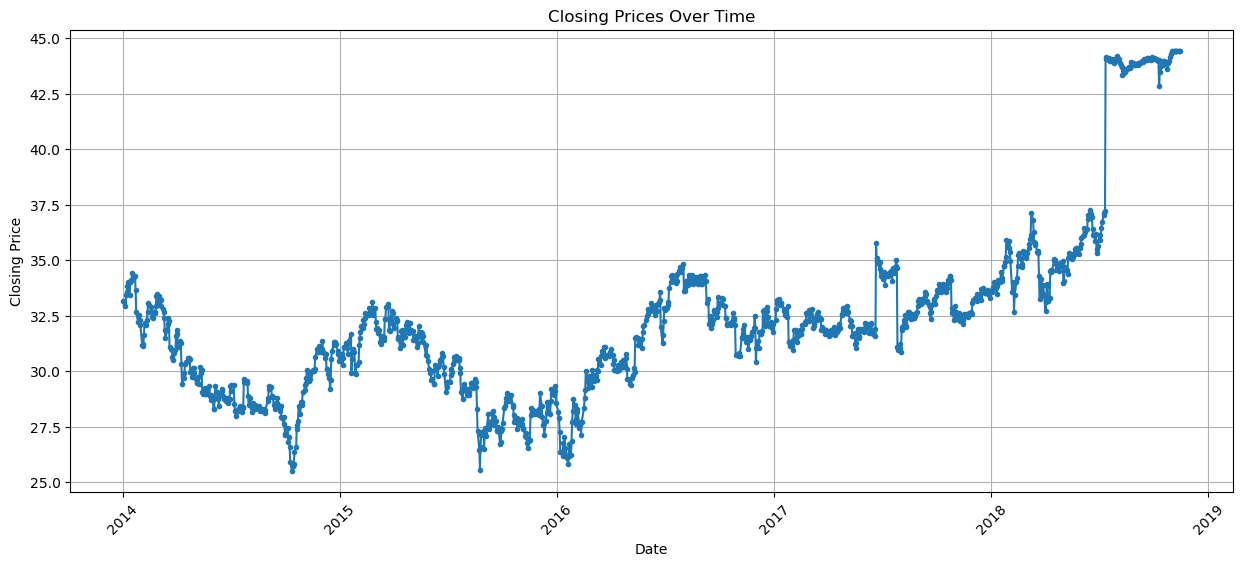

In [19]:
specific_df ['Date'] = pd.to_datetime (specific_df ['Date'])
plt.figure(figsize=(15, 6))
plt.plot(specific_df ['Date'], specific_df ['Close'], marker='.')
plt.title('Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

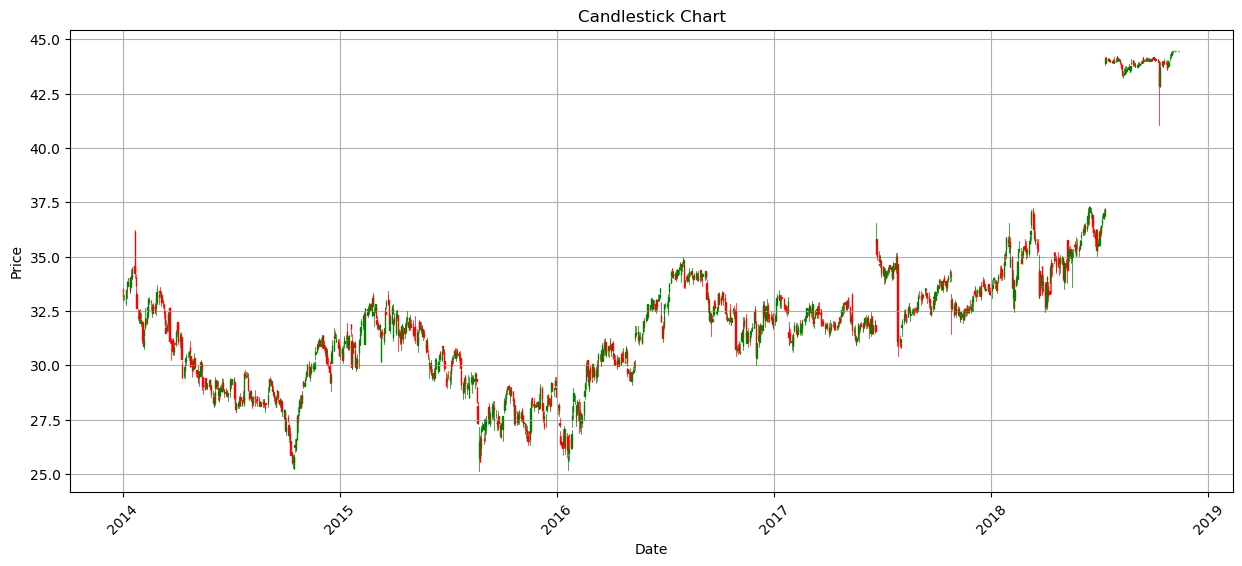

In [20]:
matplotlib_date = mdates.date2num (specific_df ['Date'])
ohlc = np.vstack ( (matplotlib_date, specific_df ['Open'], specific_df ['High'], specific_df ['Low'], specific_df ['Close'])).T
plt.figure(figsize=(15, 6))
ax = plt.subplot()
candlestick_ohlc(ax, ohlc, width=0.6, colorup='g', colordown='r')
ax.xaxis_date()
plt.title('Candlestick Chart')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

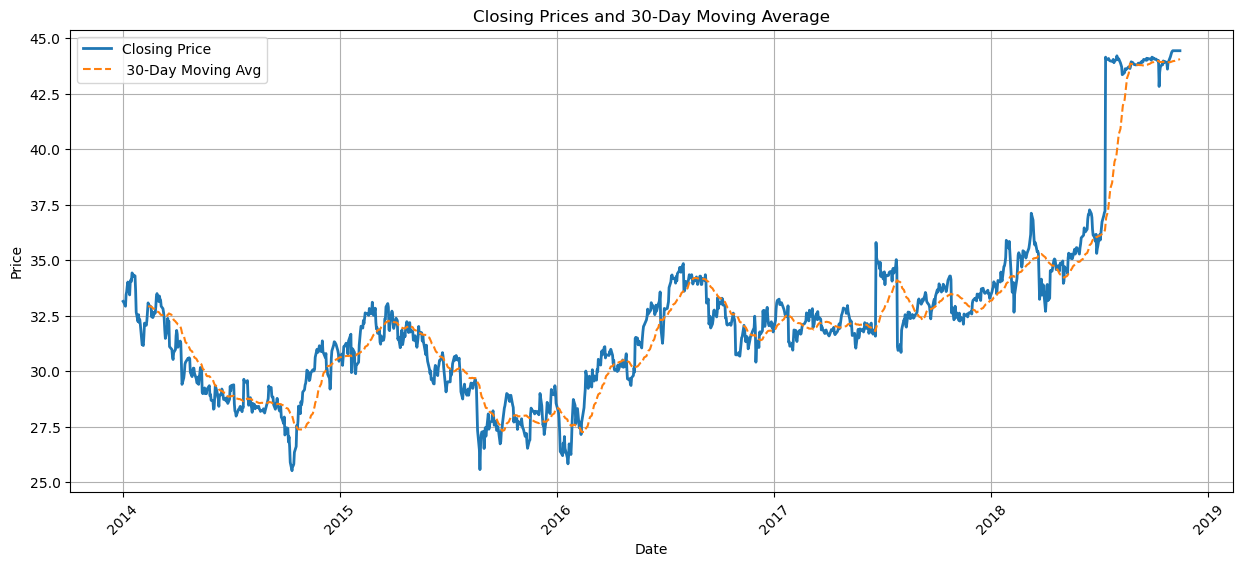

In [21]:
window = 30
plt.figure(figsize=(15, 6))
plt.plot(specific_df ['Date'], specific_df ['Close'], label='Closing Price', linewidth=2)
plt.plot(specific_df ['Date'], specific_df ['Close']. rolling (window=window).mean(), label=f' {window}-Day Moving Avg', linestyle='--')
plt.title(f'Closing Prices and {window}-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt. legend()
plt.grid(True)
plt.show()

In [22]:
new_df = specific_df.reset_index() ['Close']

In [23]:
scaler = MinMaxScaler()
scaled_data=scaler.fit_transform(np.array(new_df).reshape(-1,1))

In [24]:
train_size = int(len(scaled_data) * 0.8) # 80% for training
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [26]:
n_past = 60
X_train, y_train = [], []
for i in range(n_past, len(train_data)):
    X_train.append(train_data[i- n_past:i, 0])
    y_train.append(train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_test, y_test = [], []
for i in range(n_past, len(test_data)):
    X_test.append(test_data[i- n_past:i, 0])
    y_test.append(test_data[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

In [28]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [30]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout (0.2)) # Adding dropout to prevent overfitting
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout (0.2))
model.add(LSTM(units=50)) 
model.add(Dropout (0.2))
model.add(Dense (units=1))

In [31]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 60, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
model.compile(loss="mean_squared_error",optimizer='adam')

In [34]:
# checkpoints = ModelCheckpoint (filepath = 'my_weights.h5', save_best_only = True)
early_stopping = EarlyStopping (monitor= 'val_loss', patience=15, restore_best_weights=True)
model.fit(X_train, y_train,
    validation_data= (X_test,y_test),
    epochs=100,
    batch_size=32,
    verbose=1,
         )
#     callbacks = [checkpoints, early_stopping])

Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - loss: 0.0268 - val_loss: 0.0554
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 0.0043 - val_loss: 0.0170
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 0.0033 - val_loss: 0.0188
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 0.0028 - val_loss: 0.0231
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0034 - val_loss: 0.0099
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 0.0033 - val_loss: 0.0115
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0027 - val_loss: 0.0087
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.0025 - val_loss: 0.0066
Epoch 9/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0023 - val_loss: 0.0136
Epoch 10/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.0025 - val_loss: 0.0051
Epoch 11/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.0023 - val_loss: 0.0111
Epoch 12/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/s

In [35]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [36]:
print(math.sqrt (mean_squared_error(y_train, train_predict)))
print(math.sqrt(mean_squared_error(y_test, test_predict)))

30.693369933669718
38.344280376501125


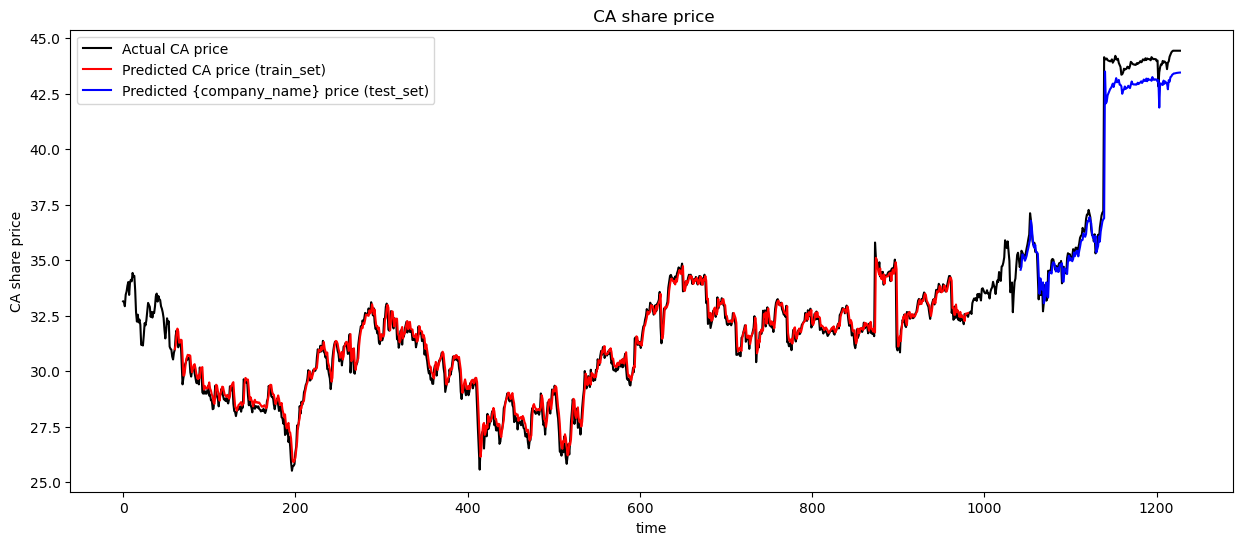

In [38]:
look_back = 60

trainPredictPlot = np.empty_like(new_df)
trainPredictPlot[:] = np.nan
trainPredictPlot [look_back: len (train_predict) +look_back] = train_predict. flatten()

testPredictPlot = np.empty_like(new_df)
testPredictPlot[:] = np.nan
test_start = len(new_df) - len(test_predict)
testPredictPlot [test_start:] = test_predict. flatten()

original_scaled_data = scaler.inverse_transform(scaled_data)

plt.figure(figsize=(15, 6))
plt.plot(original_scaled_data, color='black', label=f"Actual {company_name} price")
plt.plot(trainPredictPlot, color='red', label=f"Predicted {company_name} price (train_set)")
plt.plot(testPredictPlot, color='blue', label="Predicted {company_name} price (test_set)")
plt.title(f" {company_name} share price")
plt.xlabel("time")

plt.ylabel(f"{company_name} share price")
plt. legend()
plt.show()

In [40]:
last_sequence = X_test [-1]
last_sequence = last_sequence.reshape(1, n_past, 1)

predictions_next_10_days = []
for _ in range(10):
    next_day_prediction = model.predict(last_sequence)
    predictions_next_10_days.append(next_day_prediction [0, 0]) # Get the predicted value
    last_sequence = np.roll(last_sequence, -1, axis=1) # Shift the sequence by one day
    last_sequence [0, -1, 0] = next_day_prediction # Update the last element with the new prediction
predictions_next_10_days = scaler.inverse_transform (np.array (predictions_next_10_days).reshape(-1, 1))

print("Predictions for the next 10 days: ")

for i, prediction in enumerate (predictions_next_10_days, start=1):
    print (f"Day {i}: Predicted Price = {prediction[0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predictions for the next 10 days: 
Day 1: Predicted Price = 43.45635223388672
Day 2: Predicted Price = 42.42247772216797
Day 3: Predicted Price = 41.726593017578125
Day 4: Predicted Price = 41.323055267333984
Day 5: Predicted Price = 41.06515884399414
Day 6: Predicted Price = 40.847412109375
Day 7: Predicted Price = 40.62871551513672
Day 8: Predicted Price = 40.403717041015625
Day 9: Predicted Price = 40.178775787353516
Day 10: Predicted Price = 39.960323333740234
